In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!gcloud config set project 'medical-data-424518'

# https://console.cloud.google.com/storage/browser/medical_data_abdomen?hl=en-au&project=medical-data-424518

Updated property [core/project].


In [3]:
!pip install -U crcmod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp310-cp310-linux_x86_64.whl size=31407 sha256=bda0cd8eabae090dd1f37fb130aee2dca7963c65cd22b037f50320fe5f5f90f5
  Stored in directory: /root/.cache/pip/wheels/85/4c/07/72215c529bd59d67e3dac29711d7aba1b692f543c808ba9e86
Successfully built crcmod


In [4]:
# Create directories in Colab to maintain the structure
!mkdir -p /content/training
!mkdir -p /content/testing

!gsutil -m cp -r gs://medical_data_abdomen/Synapse/training/* /content/training/
!gsutil -m cp -r gs://medical_data_abdomen/Synapse/testing/* /content/testing/

Copying gs://medical_data_abdomen/Synapse/training/case0005_slice000.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice001.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice002.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice003.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice004.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice005.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice006.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice007.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice008.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice009.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice010.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice011.npz...
Copying gs://medical_data_abdomen/Synapse/training/case0005_slice012.npz...
Copying gs:/

In [1]:
import numpy as np
import os
import h5py
import tensorflow as tf

train_files = [f for f in os.listdir('/content/training') if f.endswith('.npz')]

X_train = []
y_train = []

for file_name in train_files:
    data = np.load(os.path.join('/content/training', file_name))
    X_train.append(data['image'])
    y_train.append(data['label'])

X_train = np.array(X_train)[..., np.newaxis]
y_train = np.array(y_train)[..., np.newaxis]

test_files = [f for f in os.listdir('/content/testing') if f.endswith('.npy.h5')]

X_test = []
y_test = []

for file_name in test_files:
    with h5py.File(os.path.join('/content/testing', file_name), 'r') as file:
        X_test.append(file['image'][:])
        y_test.append(file['label'][:])

X_test = np.concatenate(X_test, axis=0)[..., np.newaxis]
y_test = np.concatenate(y_test, axis=0)[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2211, 512, 512, 1)
y_train shape: (2211, 512, 512, 1)
X_test shape: (1568, 512, 512, 1)
y_test shape: (1568, 512, 512, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(512, 512, 1), num_classes=9):
    inputs = tf.keras.Input(input_size)

    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.3)(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.5)(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def attention_gate(x, g, inter_shape):
    theta_x = layers.Conv2D(inter_shape, (1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(g)
    add_xg = layers.add([theta_x, phi_g])
    add_xg = layers.ReLU()(add_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(add_xg)
    psi = layers.Activation('sigmoid')(psi)
    y = layers.multiply([x, psi])
    return y

def unet_attention_model(input_size=(512, 512, 1), num_classes=9):
    inputs = tf.keras.Input(input_size)

    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.3)(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.5)(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)  # Ensure c4 has correct shape
    a4 = attention_gate(c4, u6, 256)
    u6 = layers.concatenate([u6, a4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)  # Ensure c3 has correct shape
    a3 = attention_gate(c3, u7, 128)
    u7 = layers.concatenate([u7, a3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)  # Ensure c2 has correct shape
    a2 = attention_gate(c2, u8, 64)
    u8 = layers.concatenate([u8, a2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)  # Ensure c1 has correct shape
    a1 = attention_gate(c1, u9, 32)
    u9 = layers.concatenate([u9, a1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def attention_gate(x, g, inter_shape):
    theta_x = layers.Conv2D(inter_shape, (1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(g)
    add_xg = layers.add([theta_x, phi_g])
    add_xg = layers.ReLU()(add_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(add_xg)
    psi = layers.Activation('sigmoid')(psi)
    y = layers.multiply([x, psi])
    return y

def double_attention_gate(x, g, inter_shape):
    att1 = attention_gate(x, g, inter_shape)
    att2 = attention_gate(att1, g, inter_shape)
    return att2

# U-Net with double attention gates
def unet_double_attention_model(input_size=(512, 512, 1), num_classes=9):
    inputs = tf.keras.Input(input_size)

    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.3)(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.5)(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    da4 = double_attention_gate(c4, u6, 256)
    u6 = layers.concatenate([u6, da4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    da3 = double_attention_gate(c3, u7, 128)
    u7 = layers.concatenate([u7, da3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    da2 = double_attention_gate(c2, u8, 64)
    u8 = layers.concatenate([u8, da2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    da1 = double_attention_gate(c1, u9, 32)
    u9 = layers.concatenate([u9, da1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [2]:
from tensorflow.keras import backend as K
from scipy.spatial.distance import directed_hausdorff


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.one_hot(tf.cast(y_true, 'int32'), num_classes=9))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred, smooth=1e-6):
    dice = dice_loss(y_true, y_pred)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return dice + ce

def dice_coefficient_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def hausdorff_distance(y_true, y_pred):
    return max(directed_hausdorff(y_true, y_pred)[0], directed_hausdorff(y_pred, y_true)[0])

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import files

# Compile the model
model = unet_attention_model(input_size=(512, 512, 1), num_classes=9)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=combined_loss, metrics=[dice_coefficient])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_attention_model.h5', monitor='val_dice_coefficient', mode='max', save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Training
history = model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

files.download('unet_attention_model.h5')


Epoch 1/100
498/498 [==============================] - ETA: 0s - loss: 0.3040 - dice_coefficient: 0.9241
Epoch 1: val_dice_coefficient improved from -inf to 0.94082, saving model to unet_single_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


498/498 [==============================] - 165s 272ms/step - loss: 0.3040 - dice_coefficient: 0.9241 - val_loss: 0.2068 - val_dice_coefficient: 0.9408 - lr: 0.0010
Epoch 2/100
498/498 [==============================] - ETA: 0s - loss: 0.1964 - dice_coefficient: 0.9512
Epoch 2: val_dice_coefficient improved from 0.94082 to 0.95546, saving model to unet_single_model.h5
498/498 [==============================] - 126s 252ms/step - loss: 0.1964 - dice_coefficient: 0.9512 - val_loss: 0.1740 - val_dice_coefficient: 0.9555 - lr: 0.0010
Epoch 3/100
498/498 [==============================] - ETA: 0s - loss: 0.1525 - dice_coefficient: 0.9622
Epoch 3: val_dice_coefficient did not improve from 0.95546
498/498 [==============================] - 125s 251ms/step - loss: 0.1525 - dice_coefficient: 0.9622 - val_loss: 0.1574 - val_dice_coefficient: 0.9524 - lr: 0.0010
Epoch 4/100
498/498 [==============================] - ETA: 0s - loss: 0.1267 - dice_coefficient: 0.9673
Epoch 4: val_dice_coefficient imp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

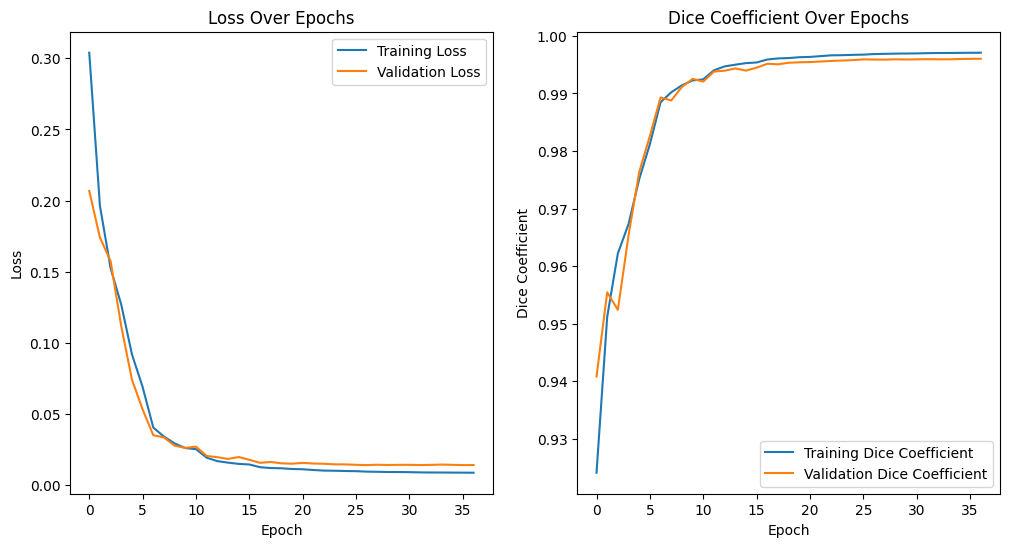

In [ ]:
# Plotting history of training to see what happens inside
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.show()

plot_training_history(history)

In [7]:
!git clone https://github.com/lucasb-eyer/pydensecrf.git
%cd pydensecrf
!pip install .


Cloning into 'pydensecrf'...
remote: Enumerating objects: 1061, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 1061 (delta 60), reused 350 (delta 51), pack-reused 689
Receiving objects: 100% (1061/1061), 2.68 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (279/279), done.
/content/pydensecrf
Processing /content/pydensecrf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405141 sha256=601898386e1906a8bd6d6cd1e5ef3208baff55b079d12667d7badf4d35a8e144
  Stored in directory: /tmp/pip-ephem-wheel-cache-aa_15_dc/wheels/1a/93/e4/321549d3c5949b950397d4e4dfd3f0b728c0dfd11eef955ed1
Successfully built pydensecrf


In [3]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

def dense_crf(img, output_probs):
    h, w, n_classes = output_probs.shape
    output_probs = np.ascontiguousarray(output_probs.transpose(2, 0, 1).reshape((n_classes, -1)))  # [C, H, W] -> [C, H*W]
    d = dcrf.DenseCRF2D(w, h, n_classes)
    U = unary_from_softmax(output_probs)
    d.setUnaryEnergy(U)
    feats = create_pairwise_gaussian(sdims=(3, 3), shape=(h, w))
    d.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    feats = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=img, chdim=2)
    d.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(5)
    result = np.argmax(Q, axis=0).reshape((h, w))
    return result

def apply_crf_to_predictions(images, predictions):
    refined_predictions = []
    for i in range(images.shape[0]):
        img = np.ascontiguousarray(images[i])
        pred = np.ascontiguousarray(predictions[i])
        refined = dense_crf(img, pred)
        refined_predictions.append(refined)
    return np.array(refined_predictions)


In [ ]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from tensorflow.keras.models import load_model

model = load_model('unet_single_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'combined_loss': combined_loss})

num_classes = 8
organ_names = ['Aorta', 'Gallbladder', 'Spleen', 'Left Kidney', 'Right Kidney', 'Liver', 'Pancreas', 'Stomach']
class_dice_scores = {i: [] for i in range(1, num_classes + 1)}
hausdorff_distances = []

batch_size = 8
num_batches = int(np.ceil(X_test.shape[0] / batch_size))

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, X_test.shape[0])
    X_test_batch = X_test[start_idx:end_idx]
    y_test_batch = y_test[start_idx:end_idx]

    y_pred_batch = model.predict(X_test_batch)

    for i in range(y_test_batch.shape[0]):
        true_label = np.squeeze(y_test_batch[i])
        pred_label = np.argmax(y_pred_batch[i], axis=-1)

        for class_idx in range(1, num_classes + 1):
            true_class = (true_label == class_idx).astype(float)
            pred_class = (pred_label == class_idx).astype(float)

            dice = dice_coefficient_np(true_class, pred_class)
            class_dice_scores[class_idx].append(dice)

        hausdorff = hausdorff_distance(true_label, pred_label)
        hausdorff_distances.append(hausdorff)

avg_class_dice_scores = {class_idx: np.mean(scores) for class_idx, scores in class_dice_scores.items()}
overall_avg_dice_score = np.mean(list(avg_class_dice_scores.values()))
avg_hausdorff_distance = np.mean(hausdorff_distances)

avg_class_dice_scores_named = {organ_names[class_idx-1]: score for class_idx, score in avg_class_dice_scores.items()}

print(f'Average Dice Score for each class: {avg_class_dice_scores_named}')
print(f'Overall Average Dice Score: {overall_avg_dice_score}')
print(f'Average Hausdorff Distance: {avg_hausdorff_distance}')


1/1 [==============================] - 0s 27ms/step
Average Dice Score for each class: {'Aorta': 0.9115373534168758, 'Gallbladder': 0.858746261685791, 'Spleen': 0.891075272580052, 'Left Kidney': 0.8899304002903803, 'Right Kidney': 0.8443166915949704, 'Liver': 0.80103394188118, 'Pancreas': 0.8813182913152128, 'Stomach': 0.7600734010172139}
Overall Average Dice Score: 0.8547539517227095
Average Hausdorff Distance: 22.06166436232805


In [4]:
from tensorflow.keras.models import load_model

model = load_model('unet_attention_model.h5', custom_objects={'dice_coefficient': dice_coefficient, 'combined_loss': combined_loss})

y_pred_test = []
batch_size = 2
for i in range(0, X_test.shape[0], batch_size):
    y_pred_batch = model.predict(X_test[i:i+batch_size])
    y_pred_test.append(y_pred_batch)
y_pred_test = np.concatenate(y_pred_test, axis=0)

refined_predictions = []
for i in range(0, X_test.shape[0], batch_size):
    refined_batch = apply_crf_to_predictions(X_test[i:i+batch_size], y_pred_test[i:i+batch_size])
    refined_predictions.append(refined_batch)
refined_predictions = np.concatenate(refined_predictions, axis=0)

num_classes = 8
organ_names = ['Aorta', 'Gallbladder', 'Spleen', 'Left Kidney', 'Right Kidney', 'Liver', 'Pancreas', 'Stomach']
class_dice_scores = {i: [] for i in range(1, num_classes + 1)}
hausdorff_distances = []

for i in range(refined_predictions.shape[0]):
    true_label = np.squeeze(y_test[i])
    pred_label = np.squeeze(refined_predictions[i])

    for class_idx in range(1, num_classes + 1):
        true_class = (true_label == class_idx).astype(float)
        pred_class = (pred_label == class_idx).astype(float)

        dice = dice_coefficient_np(true_class, pred_class)
        class_dice_scores[class_idx].append(dice)

    hausdorff = hausdorff_distance(true_label, pred_label)
    hausdorff_distances.append(hausdorff)

avg_class_dice_scores = {class_idx: np.mean(scores) for class_idx, scores in class_dice_scores.items()}
overall_avg_dice_score = np.mean(list(avg_class_dice_scores.values()))
avg_hausdorff_distance = np.mean(hausdorff_distances)

avg_class_dice_scores_named = {organ_names[class_idx-1]: score for class_idx, score in avg_class_dice_scores.items()}

print(f'Average Dice Score for each class: {avg_class_dice_scores_named}')
print(f'Overall Average Dice Score: {overall_avg_dice_score}')
print(f'Average Hausdorff Distance: {avg_hausdorff_distance}')


1/1 [==============================] - 0s 24ms/step
Average Dice Score for each class: {'Aorta': 0.7515651775045724, 'Gallbladder': 0.9299279342623173, 'Spleen': 0.889143494278809, 'Left Kidney': 0.9090837601382727, 'Right Kidney': 0.9226552785269929, 'Liver': 0.8056481061008147, 'Pancreas': 0.9227856132086687, 'Stomach': 0.8307435853027134}
Overall Average Dice Score: 0.8701941186653952
Average Hausdorff Distance: 18.979258106115005
